# Train a baseline U-Net on the fastMRI dataset

In [1]:
import functools
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_mri as tfmri

2022-08-02 17:29:22.299119: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Proportion of k-space lines in fully-sampled central region.
fully_sampled_region = 0.08

In [3]:
# If necessary, change the path names here.
fastmri_path = pathlib.Path("/media/storage/fastmri")

data_path_train = fastmri_path / "knee_multicoil_train_temp"
data_path_val = fastmri_path / "knee_multicoil_val_temp"
data_path_test = fastmri_path / "knee_multicoil_test_temp"

In [4]:
files_train = data_path_train.glob("*.h5")
files_val = data_path_val.glob("*.h5")
files_test = data_path_test.glob("*.h5")

In [5]:
# Spec for an element of the fastMRI dataset (the contents of one file).
element_spec = {
    # kspace shape is `[slices, coils, height, width]` as described in
    # https://fastmri.org/dataset/.
    '/kspace': tf.TensorSpec(shape=[None, None, None, None], dtype=tf.complex64),
    # the dataset also contains the root sum-of-squares reconstruction of the
    # multicoil k-space data, with shape `[slices, height, width]` and where
    # `height` and `width` are cropped to 320.
    '/reconstruction_rss': tf.TensorSpec(shape=[None, 320, 320], dtype=tf.float32)
}

def read_hdf5(filename, spec=None):
  """Reads an HDF file into a `dict` of `tf.Tensor`s.

  Args:
    filename: A string, the filename of an HDF5 file.
    spec: A dict of `dataset:tf.TensorSpec` or `dataset:dtype`
      pairs that specify the HDF5 dataset selected and the `tf.TensorSpec`
      or dtype of the dataset. In eager mode the spec is probed
      automatically. In graph mode `spec` has to be specified.
  """
  io_tensor = tfio.IOTensor.from_hdf5(filename, spec=spec)
  tensors = {k: io_tensor(k).to_tensor() for k in io_tensor.keys}
  return {k: tf.ensure_shape(v, spec[k].shape) for k, v in tensors.items()}

def create_fastmri_dataset(files,
                           element_spec=None,
                           batch_size=1,
                           shuffle=False):
  """Creates a `tf.data.Dataset` from a list of fastMRI HDF5 files.
  
  Args:
    files: A list of strings, the filenames of the HDF5 files.
    element_spec: The spec of an element of the dataset. See `read_hdf5` for
      more details.
    batch_size: An int, the batch size.
    shuffle: A boolean, whether to shuffle the dataset.
  """
  # Canonicalize `files` as a list of strings.
  files = list(map(str, files))
  if len(files) == 0:
    raise ValueError("no files found")
  # Make a `tf.data.Dataset` from the list of files.
  ds = tf.data.Dataset.from_tensor_slices(files)
  # Read the data in the file.
  ds = ds.map(functools.partial(read_hdf5, spec=element_spec))
  # print(ds)
  # The first dimension of the inputs is the slice dimension. Split each
  # multi-slice element into multiple single-slice elements, as the
  # reconstruction is performed on a slice-by-slice basis.
  split_slices = lambda x: tf.data.Dataset.from_tensor_slices(x)
  ds = ds.flat_map(split_slices)
  # Remove slashes.
  ds = ds.map(lambda x: {k[1:]: v for k, v in x.items()})
  # TODO: create mask.

  # # TODO: create labels.
  # if shuffle:
  #   ds = ds.shuffle(buffer_size=100)
  # # Batch the elements.
  # ds = ds.batch(batch_size)
  # ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [6]:

batch_size = 1

ds_train = create_fastmri_dataset(files_train,
                                  element_spec=element_spec,
                                  batch_size=batch_size,
                                  shuffle=True)

ds_val = create_fastmri_dataset(files_val,
                                element_spec=element_spec,
                                batch_size=batch_size,
                                shuffle=False)

# ds_test = create_fastmri_dataset(files_test,
#                                  element_spec=element_spec,
#                                  batch_size=batch_size,
#                                  shuffle=False)

2022-08-02 17:29:36.908974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 17:29:37.798985: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22290 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-08-02 17:29:37.799498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22304 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6
2022-08-02 17:29:38.076969: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that t

In [7]:
for example in ds_train.take(16):
  print(example['kspace'].shape)

(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)
(15, 640, 372)


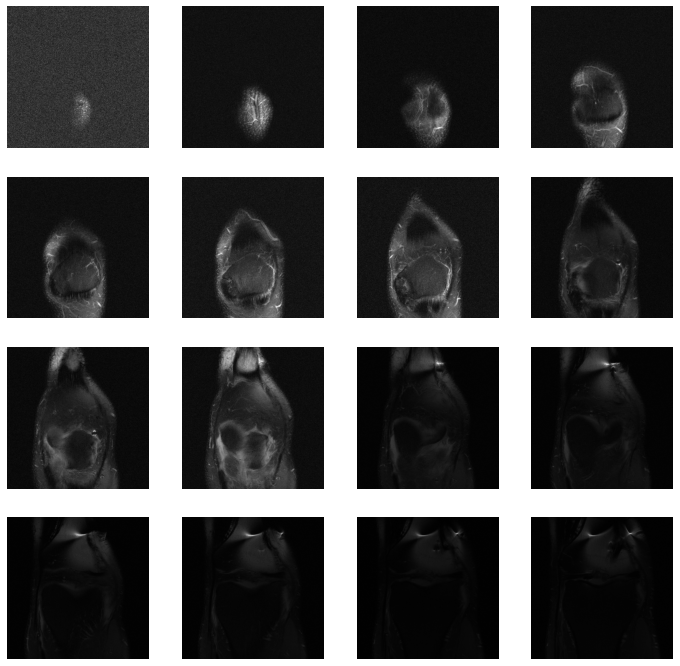

In [8]:
def show_examples(ds, fn):
  _, axs = plt.subplots(4, 4, figsize=(12, 12))
  for index, example in enumerate(ds.take(16)):
    i, j = index // 4, index % 4
    axs[i, j].imshow(fn(example), cmap='gray')
    axs[i, j].axis('off')
  plt.show()

display_fn = lambda example: example['reconstruction_rss'].numpy()
show_examples(ds_train, display_fn)

In [16]:
def reconstruct_zerofilled(kspace):
  image_shape = tf.shape(kspace)[-2:]
  image = tfmri.recon.adjoint(kspace, image_shape)
  return image

def compute_sensitivities(kspace):
  def box(freq):
    cutoff = fully_sampled_region * np.pi
    result = tf.where(tf.math.abs(freq) < cutoff, 1, 0)
    return result
  filt_kspace = tfmri.signal.filter_kspace(kspace,
                                           filter_fn=box,
                                           filter_rank=1)
  filt_image = reconstruct_zerofilled(filt_kspace)
  sensitivities = tfmri.coils.estimate_sensitivities(filt_image, coil_axis=-3)
  return sensitivities

Tensor("args_0:0", shape=(None, None, None), dtype=complex64)


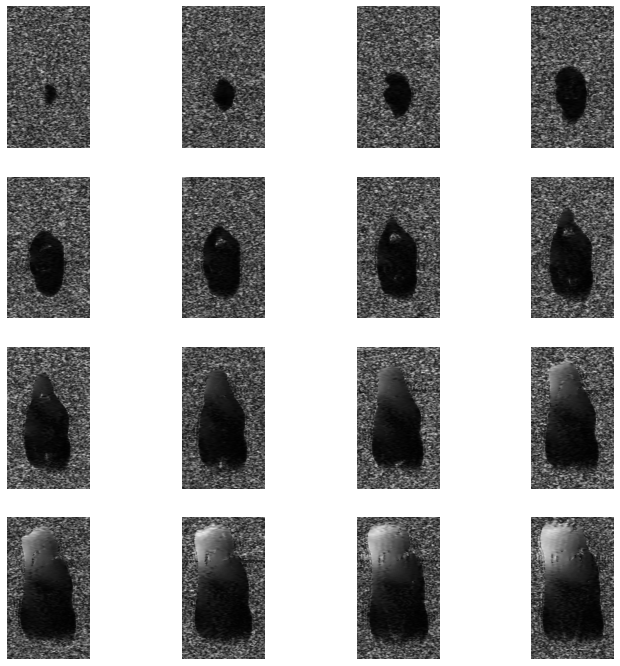

In [21]:
def insert_sensitivities(example):
  example['sensitivities'] = compute_sensitivities(example['kspace'])
  return example

ds_temp = ds_train.map(insert_sensitivities)

display_fn = lambda example: np.abs(example['sensitivities'].numpy())[0, ...]
show_examples(ds_temp, display_fn)

TypeError: Invalid shape (15, 640, 372) for image data

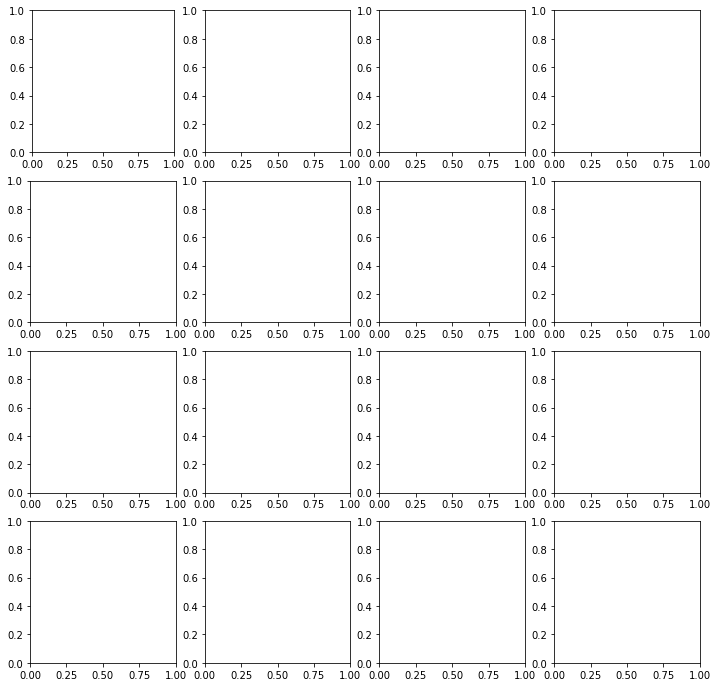

In [13]:
def display_fn(example):
  image = reconstruct_zerofilled(example['kspace'])
  image = tf.math.abs(image)
  return image

show_examples(ds_train, display_fn)

In [ ]:
def subsample(example):
  """Subsamples a fastMRI example (single slice).

  Args:
    ds: A `tf.data.Dataset` object.
  """
  kspace = example['kspace']
  num_lines = tf.shape(kspace)[-1]
  density_1d = tfmri.sampling.density_grid(shape=[num_lines],
                                           inner_density=1.0,
                                           inner_cutoff=0.08,
                                           outer_cutoff=0.08,
                                           outer_density=0.25)
  mask_1d = tfmri.sampling.random_mask(shape=[num_lines], density=density_1d)
  mask_2d = tf.tile(mask_1d, tf.shape(kspace)[-2:])
  example['kspace'] *= mask_1d
  example['mask'] = mask_2d
  return example

train_ds = ds_train.map(subsample)

In [1]:
model = tfmri.models.UNet2D(filters=[32, 64, 128], kernel_size=3)

model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=[tfmri.metrics.PSNR(),
                       tfmri.metrics.SSIM()])

NameError: name 'tfmri' is not defined

In [ ]:
model.fit(ds_train, epochs=1, validation_data=ds_val)